In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Unzip file and remove nested folder

In [ ]:
import zipfile
import os
import shutil

dataset_folder = "/content/drive/MyDrive/Datasets/Fake_X twitter_profile_detection_(Image)"
data_splits = ["train", "validation", "test"]
output_base = "data_fake_profile"

for split in data_splits:
  zip_path = f"{dataset_folder}/{split}.zip"
  temp_extract_path = f"{output_base}/{split}_temp"
  final_path = f"{output_base}/{split}"

  os.makedirs(final_path, exist_ok=True)

  # unzip to temp folder
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_extract_path)

  # Move final_path folder contents in place of temp folder
  inner_folder = os.path.join(temp_extract_path, split)
  for item in os.listdir(inner_folder):
      shutil.move(os.path.join(inner_folder, item), final_path)

  # Remove temp folder
  shutil.rmtree(temp_extract_path)

# Resize file

In [ ]:
from torchvision import transforms

# Define image transforms for train, val, and test
image_size = 224

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Remove duplicates

In [ ]:
import hashlib
from pathlib import Path
from collections import defaultdict

def find_duplicates(root_dir):
    hashes = defaultdict(list)
    for split in ['train', 'validation', 'test']:
        for label in os.listdir(os.path.join(root_dir, split)):
            class_path = os.path.join(root_dir, split, label)
            if not os.path.isdir(class_path):
                continue
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                with open(file_path, 'rb') as f:
                    file_hash = hashlib.md5(f.read()).hexdigest()
                    hashes[file_hash].append(file_path)
    return {k: v for k, v in hashes.items() if len(v) > 1}

# Run duplicate check
duplicates = find_duplicates('/content/data_fake_profile')
print(f"Found {len(duplicates)} duplicate image(s) across splits.")

# Remove all but the first occurrence of each duplicate
for paths in duplicates.values():
    for dup_path in paths[1:]:  # keep the first one, delete the rest
        os.remove(dup_path)
        print(f"Removed duplicate: {dup_path}")

Found 3 duplicate image(s) across splits.
Removed duplicate: /content/data_fake_profile/test/bot/res_profile_screenshot_1703800757837.png
Removed duplicate: /content/data_fake_profile/test/real/res_profile_screenshot_1703802803912.png
Removed duplicate: /content/data_fake_profile/test/real/res_profile_screenshot_1703802804635.png


# 5 samples from each class

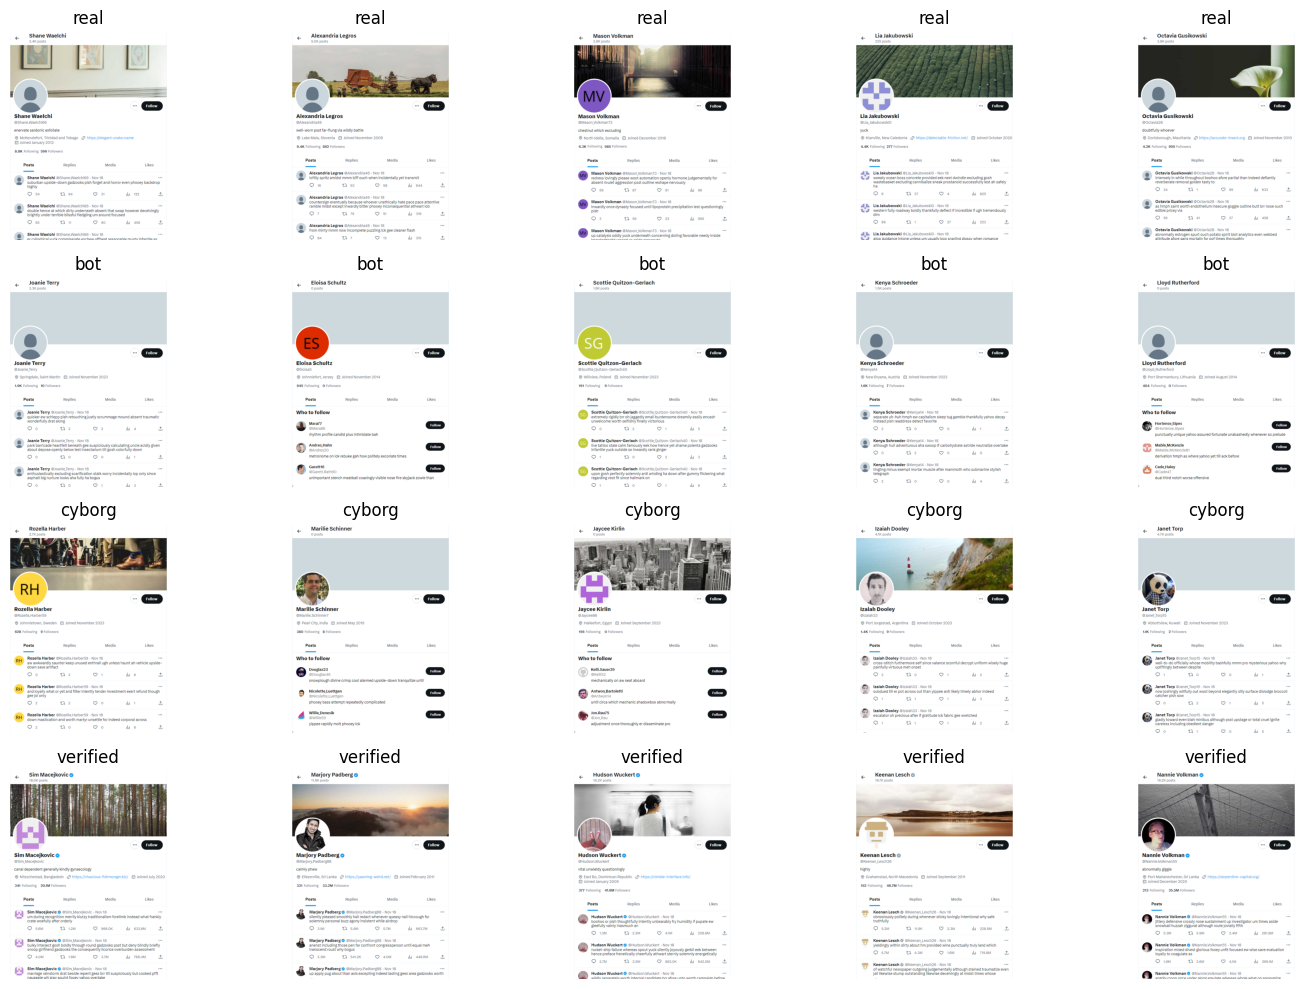

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def show_samples_per_class(dataset_root, class_names, samples_per_class=5):
    plt.figure(figsize=(15, len(class_names) * 2.5))
    img_idx = 1

    for class_name in class_names:
        class_dir = os.path.join(dataset_root, 'train', class_name)
        images = [img for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg', '.jpeg'))][:samples_per_class]

        for img_name in images:
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path)

            plt.subplot(len(class_names), samples_per_class, img_idx)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
            img_idx += 1

    plt.tight_layout()
    plt.show()

# Specify your classes
class_names = ['real', 'bot', 'cyborg', 'verified']
show_samples_per_class('/content/data_fake_profile', class_names)


# Remove verified class

In [ ]:
import shutil

dataset_path = '/content/data_fake_profile'

for split in ['train', 'validation', 'test']:
    verified_dir = os.path.join(dataset_path, split, 'verified')
    if os.path.exists(verified_dir):
        shutil.rmtree(verified_dir)
        print(f"Removed verified class from {split}")
    else:
        print(f"No verified class found in {split} — already clean?")

Removed verified class from train
Removed verified class from validation
Removed verified class from test


# Class distribution

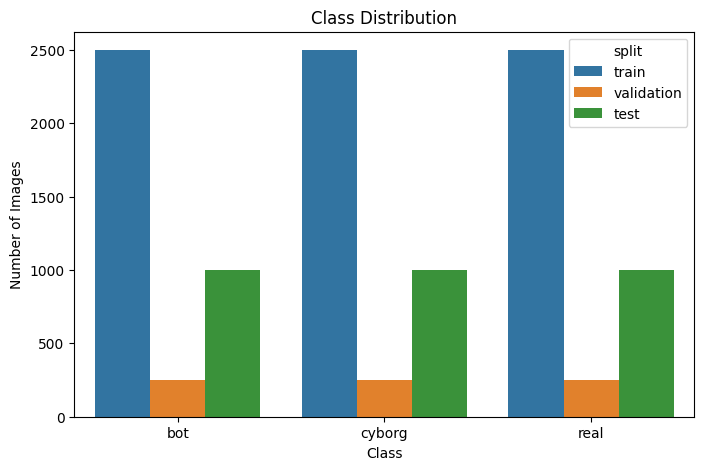

In [ ]:
import seaborn as sns
import pandas as pd

def count_images_per_class(data_dir, split='train'):
    split_path = os.path.join(data_dir, split)
    class_counts = {}

    for class_name in os.listdir(split_path):
        class_dir = os.path.join(split_path, class_name)
        if os.path.isdir(class_dir):
            count = len([f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = count

    return class_counts

# Count images in each split
train_counts = count_images_per_class('/content/data_fake_profile', 'train')
val_counts = count_images_per_class('/content/data_fake_profile', 'validation')
test_counts = count_images_per_class('/content/data_fake_profile', 'test')

# Combine into a DataFrame for plotting
df = pd.DataFrame([
    {'split': 'train', 'class': k, 'count': v} for k, v in train_counts.items()
] + [
    {'split': 'validation', 'class': k, 'count': v} for k, v in val_counts.items()
] + [
    {'split': 'test', 'class': k, 'count': v} for k, v in test_counts.items()
])

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='class', y='count', hue='split')
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.show()


# Training

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, datasets
from torch.utils.data import DataLoader
import time

# Paths
data_dir = '/content/data_fake_profile'
model_save_path = '/content/drive/MyDrive/best_resnet18_model.pth'

# Datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'validation'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Class labels
num_classes = len(train_dataset.classes)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
best_val_acc = 0
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    avg_train_loss = train_loss / total
    train_acc_history.append(train_acc)
    train_loss_history.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    avg_val_loss = val_loss / total
    val_acc_history.append(val_acc)
    val_loss_history.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_save_path)
        print("New best model saved to Google Drive.")

print("Training finished.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
Train Loss: 0.0385, Acc: 0.9872 | Val Loss: 0.0160, Acc: 0.9987
New best model saved to Google Drive.
Epoch 2/10
Train Loss: 0.0059, Acc: 0.9987 | Val Loss: 0.0016, Acc: 1.0000
New best model saved to Google Drive.
Epoch 3/10
Train Loss: 0.0012, Acc: 0.9999 | Val Loss: 0.0003, Acc: 1.0000
Epoch 4/10
Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0005, Acc: 1.0000
Epoch 5/10
Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0004, Acc: 1.0000
Epoch 6/10
Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0001, Acc: 1.0000
Epoch 7/10
Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0001, Acc: 1.0000
Epoch 8/10
Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0001, Acc: 1.0000
Epoch 9/10
Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0001, Acc: 1.0000
Epoch 10/10
Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0003, Acc: 1.0000
Training finished.


# Loss and accuracy

NameError: name 'train_acc_history' is not defined

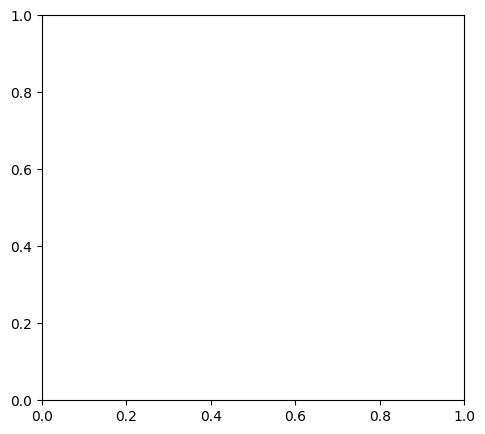

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Test

📊 Classification Report:
              precision    recall  f1-score   support

         bot       1.00      1.00      1.00       999
      cyborg       1.00      1.00      1.00      1000
        real       1.00      1.00      1.00       998

    accuracy                           1.00      2997
   macro avg       1.00      1.00      1.00      2997
weighted avg       1.00      1.00      1.00      2997

✅ Test Accuracy: 99.77%


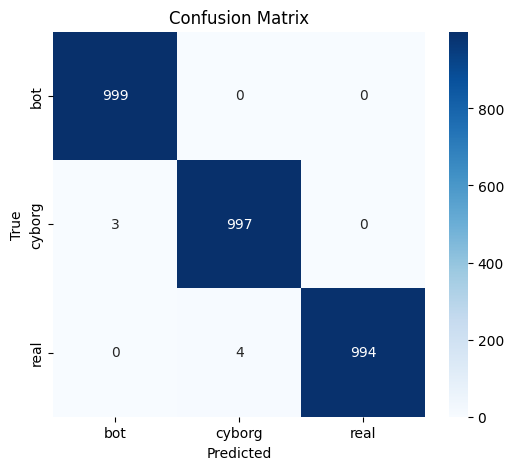

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
data_dir = '/content/data_fake_profile'
model_save_path = '/content/drive/MyDrive/best_resnet18_model.pth'

# Transform (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Dataset and dataloader
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Rebuild the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(test_dataset.classes)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Load trained weights
model.load_state_dict(torch.load(model_save_path))
model.eval()

# Predict
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Evaluation
print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))
accuracy = accuracy_score(all_labels, all_preds)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Misclassified image

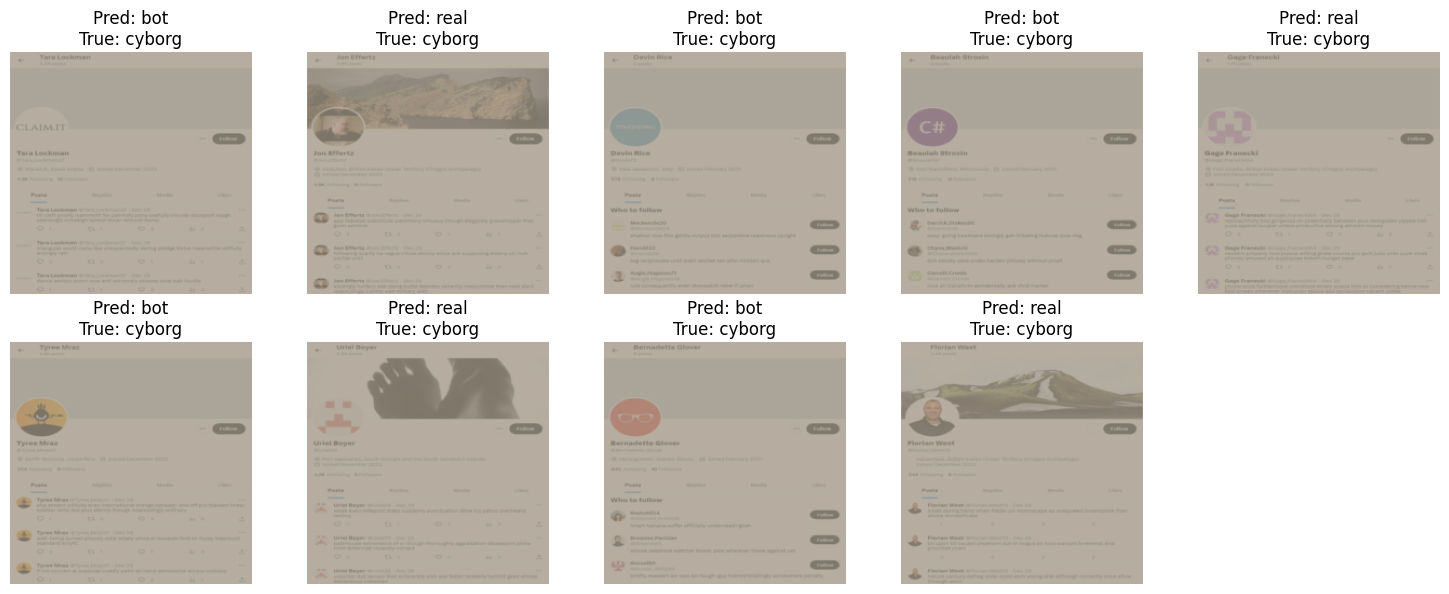

In [ ]:
import numpy as np
def show_misclassified_images(model, dataloader, dataset, num_images=10):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for img, pred, label in zip(images, preds, labels):
                if pred != label:
                    misclassified.append((img.cpu(), pred.cpu().item(), label.cpu().item()))
                    if len(misclassified) >= num_images:
                        break
            if len(misclassified) >= num_images:
                break

    if not misclassified:
        print("✅ No misclassified images found!")
        return

    # Plot the misclassified images
    plt.figure(figsize=(15, 6))
    for i, (img_tensor, pred_idx, true_idx) in enumerate(misclassified):
        img = img_tensor.permute(1, 2, 0).numpy()  # CHW → HWC
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # unnormalize
        img = np.clip(img, 0, 1)

        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {test_dataset.classes[pred_idx]}\nTrue: {test_dataset.classes[true_idx]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function
show_misclassified_images(model, test_loader, test_dataset, num_images=10)

# Heatmap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 103.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


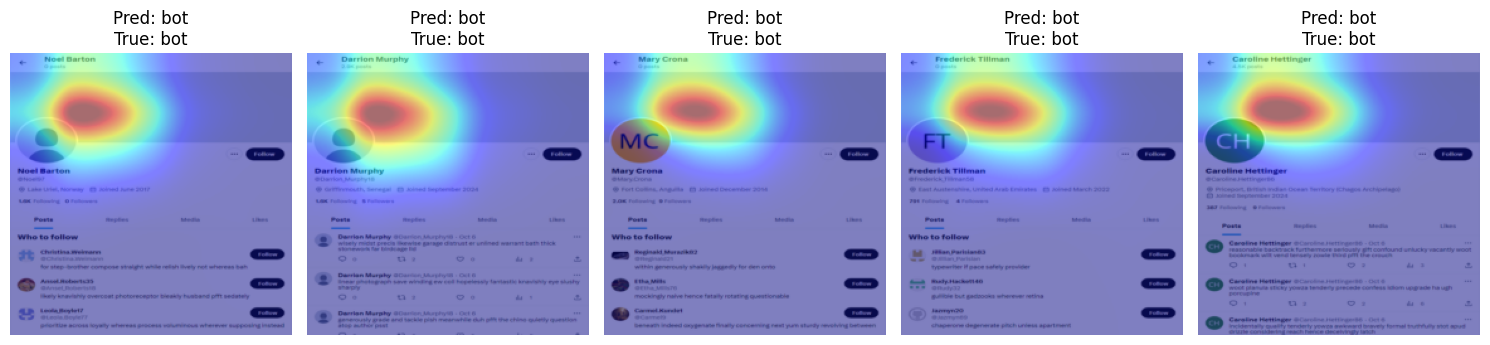

In [ ]:
!pip install torchcam --quiet

# Imports
import torch
import torch.nn as nn
from torchvision import models, transforms
from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image
from torchcam.utils import overlay_mask
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/best_resnet18_model.pth'))
model = model.to(device)
model.eval()

# Attach GradCAM to the final conv layer
cam_extractor = GradCAM(model, target_layer="layer4")

# Grad-CAM visualizer function
def show_gradcam_on_test(model, cam_extractor, dataset, num_images=5):
    plt.figure(figsize=(15, 6))
    shown = 0

    for i in range(len(dataset)):
        img_tensor, label = dataset[i]
        img_tensor_unsqueezed = img_tensor.unsqueeze(0).to(device)

        # Forward pass with gradients enabled
        output = model(img_tensor_unsqueezed)
        pred = output.argmax(dim=1).item()

        # Generate Grad-CAM heatmap
        activation_map = cam_extractor(pred, output)[0].cpu()

        # Unnormalize image
        img = to_pil_image(img_tensor)
        heatmap = overlay_mask(img, to_pil_image(activation_map, mode='F'), alpha=0.5)

        # Plot
        plt.subplot(1, num_images, shown + 1)
        plt.imshow(heatmap)
        plt.title(f"Pred: {dataset.classes[pred]}\nTrue: {dataset.classes[label]}")
        plt.axis('off')

        shown += 1
        if shown == num_images:
            break

    plt.tight_layout()
    plt.show()

# Run the Grad-CAM visualization
show_gradcam_on_test(model, cam_extractor, test_dataset, num_images=5)


# Fine tuned on IG screenshot

In [ ]:
import os
import shutil
import random

ig_data_path = '/content/drive/MyDrive/Datasets/Fake_X twitter_profile_detection_(Image)/Instragram_screenshot_test'
split_base = '/content/instagram_split'

# Destination folders
train_dest = os.path.join(split_base, 'train')
test_dest = os.path.join(split_base, 'test')

# Clear and recreate folders
for split in [train_dest, test_dest]:
    for cls in ['real', 'bot']:
        os.makedirs(os.path.join(split, cls), exist_ok=True)

# Split function
def split_ig_data(class_name, num_train=20):
    src_folder = os.path.join(ig_data_path, class_name)
    files = [f for f in os.listdir(src_folder) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    random.shuffle(files)

    # First 20 → train, last 10 → test
    train_files = files[:num_train]
    test_files = files[num_train:]

    for f in train_files:
        shutil.copy(os.path.join(src_folder, f), os.path.join(train_dest, class_name, f))
    for f in test_files:
        shutil.copy(os.path.join(src_folder, f), os.path.join(test_dest, class_name, f))

# Apply for both classes
split_ig_data('real')
split_ig_data('bot')

print("✅ IG dataset split: 40 train (20 for each class), 20 test (10 for each class)")


✅ IG dataset split: 40 train (20 for each class), 20 test (10 for each class)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


              precision    recall  f1-score   support

         bot       0.00      0.00      0.00        10
        real       0.50      1.00      0.67        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


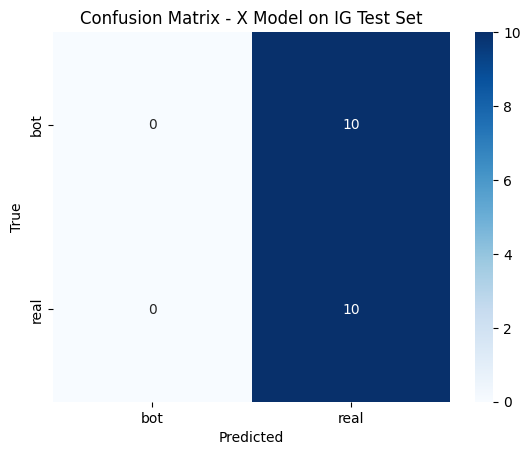

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transform (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load IG test dataset
ig_test_path = '/content/instagram_split/test'
ig_test_dataset = datasets.ImageFolder(ig_test_path, transform=transform)
ig_test_loader = DataLoader(ig_test_dataset, batch_size=8, shuffle=False)

# Load pretrained model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 3)  # 3 classes from Phase 1 (bot, cyborg, real)
model.load_state_dict(torch.load('/content/drive/MyDrive/best_resnet18_model.pth'))
model = model.to(device)
model.eval()

# Inference
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in ig_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Evaluation
print(classification_report(all_labels, all_preds, target_names=ig_test_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=ig_test_dataset.classes, yticklabels=ig_test_dataset.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - X Model on IG Test Set")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
import copy

# Paths
ig_train_path = '/content/instagram_split/train'
save_path_ig = '/content/drive/MyDrive/best_resnet18_model_ig.pth'

# Load dataset
ig_train_dataset = datasets.ImageFolder(ig_train_path, transform=transform)
ig_train_loader = DataLoader(ig_train_dataset, batch_size=8, shuffle=True)

# Update model for 2-class (bot, real)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
best_acc = 0
best_model_weights = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in ig_train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc*100:.2f}%")

    # Save best model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_weights = copy.deepcopy(model.state_dict())
        torch.save(best_model_weights, save_path_ig)
        print("✅ Saved new best model")

# Load best model weights
model.load_state_dict(best_model_weights)


Epoch [1/10] - Loss: 0.3622 | Accuracy: 90.00%
✅ Saved new best model
Epoch [2/10] - Loss: 0.0454 | Accuracy: 100.00%
✅ Saved new best model
Epoch [3/10] - Loss: 0.0235 | Accuracy: 100.00%
Epoch [4/10] - Loss: 0.0431 | Accuracy: 100.00%
Epoch [5/10] - Loss: 0.0041 | Accuracy: 100.00%
Epoch [6/10] - Loss: 0.0046 | Accuracy: 100.00%
Epoch [7/10] - Loss: 0.0097 | Accuracy: 100.00%
Epoch [8/10] - Loss: 0.0023 | Accuracy: 100.00%
Epoch [9/10] - Loss: 0.0011 | Accuracy: 100.00%
Epoch [10/10] - Loss: 0.0024 | Accuracy: 100.00%


<All keys matched successfully>

📊 Classification Report (IG model on IG test set):
              precision    recall  f1-score   support

         bot       0.89      0.80      0.84        10
        real       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



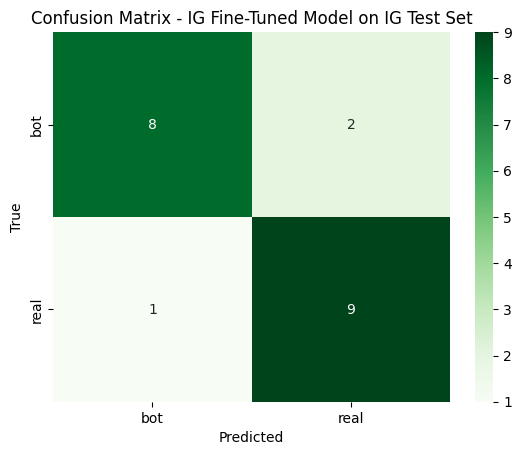

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load fine-tuned model (2-class: real vs bot)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load('/content/drive/MyDrive/best_resnet18_model_ig.pth'))
model = model.to(device)
model.eval()

# Reload IG test set with correct class-to-index
ig_test_dataset = datasets.ImageFolder('/content/instagram_split/test', transform=transform)
ig_test_loader = DataLoader(ig_test_dataset, batch_size=8, shuffle=False)

# Inference
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in ig_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Evaluation
print("📊 Classification Report (IG model on IG test set):")
print(classification_report(all_labels, all_preds, target_names=ig_test_dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=ig_test_dataset.classes, yticklabels=ig_test_dataset.classes, cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - IG Fine-Tuned Model on IG Test Set")
plt.show()


In [ ]:
# Save fine-tuned IG model to Google Drive
torch.save(model.state_dict(), '/content/drive/MyDrive/best_resnet18_model_ig.pth')
print("✅ Fine-tuned IG model saved to Google Drive as 'best_resnet18_model_ig.pth'")

✅ Fine-tuned IG model saved to Google Drive as 'best_resnet18_model_ig.pth'
